<center> <h1> Mean-Variance Optimization <h1/> <center/>

This notebook is a modified version of the one presented on MOSEK's website: 

## Imports

In [30]:
import sys
import os
import re
import glob
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader

In [31]:
COLORS = ["#354F60","#BC0E4C","#FFC501"];

## Definition of Data

In [419]:
# Linear return statistics on the investment horizon
mu = np.array([0.07197349, 0.15518171, 0.17535435, 0.0898094 , 0.42895777, 0.39291844, 0.32170722, 0.18378628])
Sigma = np.array([
        [0.09460323, 0.03735969, 0.03488376, 0.03483838, 0.05420885, 0.03682539, 0.03209623, 0.03271886],
        [0.03735969, 0.07746293, 0.03868215, 0.03670678, 0.03816653, 0.03634422, 0.0356449 , 0.03422235],
        [0.03488376, 0.03868215, 0.06241065, 0.03364444, 0.03949475, 0.03690811, 0.03383847, 0.02433733],
        [0.03483838, 0.03670678, 0.03364444, 0.06824955, 0.04017978, 0.03348263, 0.04360484, 0.03713009],
        [0.05420885, 0.03816653, 0.03949475, 0.04017978, 0.17243352, 0.07886889, 0.06999607, 0.05010711],
        [0.03682539, 0.03634422, 0.03690811, 0.03348263, 0.07886889, 0.09093307, 0.05364518, 0.04489357],
        [0.03209623, 0.0356449 , 0.03383847, 0.04360484, 0.06999607, 0.05364518, 0.09649728, 0.04419974],
        [0.03271886, 0.03422235, 0.02433733, 0.03713009, 0.05010711, 0.04489357, 0.04419974, 0.08159633]
      ])

## Efficient Frontier: Analytical

We start by showing the efficient frontier via the analytical expression obtained in the thesis.

In [33]:
def OptimalPortfolio(targetReturn, mu, Sigma):
    
    e = np.ones(len(mu));
    aux1 = np.vstack((mu,e)).transpose();
    aux2 = np.array([targetReturn, 1]);
    invSigma = np.linalg.inv(Sigma);
    A = np.dot(np.dot(aux1.transpose(), invSigma), aux1);
    invA = np.linalg.inv(A);
    
    # Then we find the optimal portfolio
    x_star = np.dot(invSigma, np.dot(aux1, np.dot(invA, aux2)));
    mu_star = np.dot(x_star,mu);
    sigma_star = np.sqrt(np.dot(aux2, np.dot(invA, aux2)));
    
    # In addition, we compute the global min variance portfolio.
    gmv_star = 1/A[1,1] * np.dot(invSigma, e);
    sigma_gmv = np.sqrt(np.dot(gmv_star, np.dot(Sigma, gmv_star)));
    mu_gmv = np.dot(gmv_star,mu);
    
    return (x_star, mu_star, sigma_star, mu_gmv, sigma_gmv);

Then we define a sequence of target returns for which we want to find the optimal portfolio.

In [34]:

targetReturns = np.linspace(0.000, 0.50, num=500);
sigma = np.sqrt(np.diag(Sigma));

optimalReturns = [];
optimalStandardDeviations = [];
optimalPortfolios = [];

for targetReturn in targetReturns:
    
    x_star, mu_star, sigma_star, mu_gmv, sigma_gmv = OptimalPortfolio(targetReturn, mu, Sigma);
    optimalPortfolios.append(x_star);
    optimalReturns.append(mu_star);
    optimalStandardDeviations.append(sigma_star);

optimalReturns = np.array(optimalReturns);
optimalStandardDeviations = np.array(optimalStandardDeviations); 


Then we can plot the efficient frontier together with the assets.

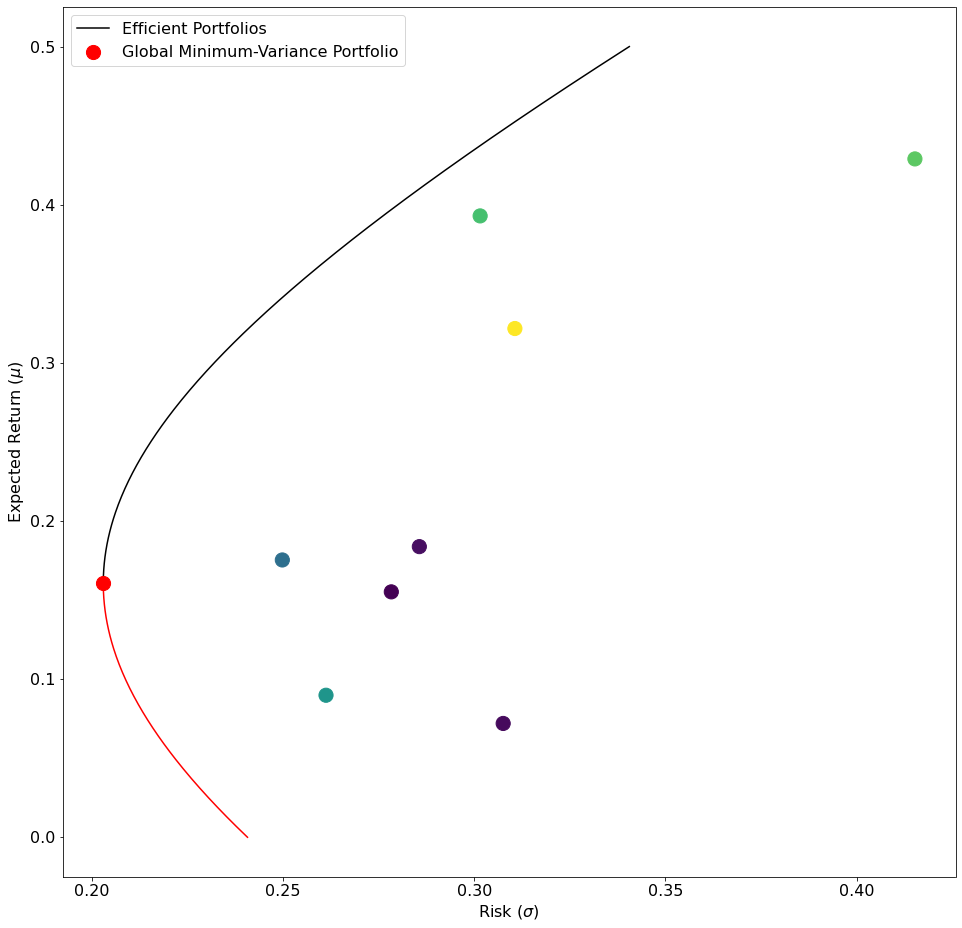

In [35]:
plt.figure(figsize=(16,16));

# Layout configurations
plt.rcParams['xtick.labelsize'] = 16.0;
plt.rcParams['ytick.labelsize'] = 16.0;

c = np.sqrt((20 * np.random.rand(len(mu)))**2);

# Plot assets
plt.scatter(sigma, mu, c=c, s=200);

# Plot above global mean-variance portfolio
selectedRange = optimalReturns > mu_gmv;
plt.plot(optimalStandardDeviations[selectedRange == False], optimalReturns[selectedRange == False], c="red");
plt.plot(optimalStandardDeviations[selectedRange], optimalReturns[selectedRange], c="black", label="Efficient Portfolios");

# Plot global minimum-variance portfolio
plt.scatter(sigma_gmv, mu_gmv, c="red", s=200, zorder=2, label="Global Minimum-Variance Portfolio");

# Show legend and axis labels
plt.xlabel("Risk ($\sigma$)", fontsize=16);
plt.ylabel("Expected Return ($\mu$)", fontsize=16);
plt.legend(fontsize=16);

# Save and show plot
plt.savefig('./Plots/EfficientFrontier.png', dpi=200);
plt.show()

## Efficient Frontier: Linear Program with Conic Constraint

We follow the implementation from MOSEK's cookbook.

In [246]:
N = mu.shape[0] # Number of securities 
gamma2 = 0.05 # Risk limit

# Cholesky factor of S to use in conic risk constraint
G = np.linalg.cholesky(Sigma)

In [248]:
def MVO(CF, MV, N, gammas = np.linspace(0.02, 0.115, 10000)):
    
    G = CF;
    mu = MV;

    with Model("markowitz") as M: 

        # Settings
        #M.setLogHandler(sys.stdout)

        # Decision variable (fraction of holdings in each security)
        # The variable x is the fraction of holdings in each security.
        x = M.variable("x", N, Domain.unbounded())

        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1)) 

        # Objective
        gamma2 = M.parameter('gamma2');
        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(mu, x))

        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(gamma2, 0.5, Expr.mul(G.T, x)), Domain.inRotatedQCone())

        columns = ["delta", "obj", "return", "risk"] + ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
        df_result = pd.DataFrame(columns=columns)

        for idx, gamma in enumerate(gammas):

            # Update parameter
            gamma2.setValue(gamma);

            # Solve optimization
            M.solve();

            prosta = M.getProblemStatus();

            if prosta !=ProblemStatus.PrimalInfeasible:
                
                # Print status
                # print("The program is feasible for gamma = {}.".format(gamma));
                
                # Save results
                portfolio_return = mu @ x.level();
                portfolio_risk = np.sqrt(x.level().T @ Sigma @ x.level());
                row = pd.DataFrame([gamma, M.primalObjValue(), portfolio_return,
                                 portfolio_risk] + list(x.level()), index=columns, columns=[idx]);

                # Concatenate with exisiting results
                df_result = pd.concat([df_result, row.T], axis=0);

            else:
                continue;
                # print("The program is primal infeasible for gamma = {}.".format(gamma));
                
        return df_result;

Then we can add a shorting constraint.

In [253]:
def MVO_noShorting(CF, MV, N, gammas = np.linspace(0.02, 0.115, 10000)):
    
    G = CF;
    mu = MV;
    
    with Model("markowitz") as M: 
    
        # Settings
        #M.setLogHandler(sys.stdout)

        # Decision variable (fraction of holdings in each security)
        # The variable x is the fraction of holdings in each security.
        x = M.variable("x", N, Domain.greaterThan(0.0))

        # Objective
        gamma2 = M.parameter('gamma2');
        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(mu, x))

        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(gamma2, 0.5, Expr.mul(G.T, x)), Domain.inRotatedQCone())

        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1)) 

        # Then we move on to solve it

        columns = ["delta", "obj", "return", "risk"] + ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
        df_result_shorting = pd.DataFrame(columns=columns)

        for idx, gamma in enumerate(gammas):

            # Update parameter
            gamma2.setValue(gamma);

            # Solve optimization
            M.solve();

            prosta = M.getProblemStatus();

            if prosta !=ProblemStatus.PrimalInfeasible:
                
                # Print status
                # print("The program is feasible for gamma = {}.".format(gamma));

                # Save results
                portfolio_return = mu @ x.level();
                portfolio_risk = np.sqrt(x.level().T @ Sigma @ x.level());
                row = pd.DataFrame([gamma, M.primalObjValue(), portfolio_return,
                                 portfolio_risk] + list(x.level()), index=columns, columns=[idx]);

                # Concatenate with exisiting results
                df_result_shorting = pd.concat([df_result_shorting, row.T], axis=0);

            else:
                continue;
                # print("The program is primal infeasible for gamma = {}.".format(gamma));
                
        return df_result_shorting;
        

In [411]:
df_result_shorting = MVO(G, mu, N, gammas = np.linspace(0.02, 0.115, 100))
df_result = MVO_noShorting(G, mu, N, gammas = np.linspace(0.02, 0.115, 100))

Then we can plot the results.

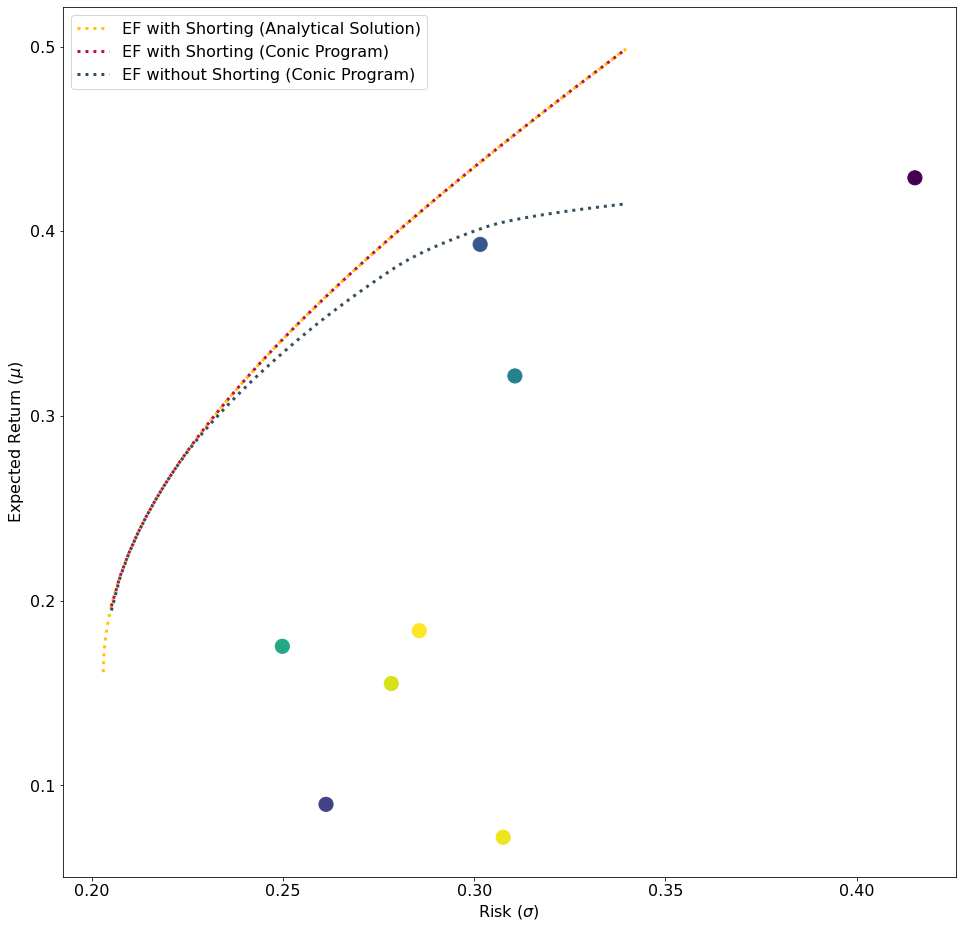

In [256]:
plt.figure(figsize=(16,16));

# Layout configurations
plt.rcParams['xtick.labelsize'] = 16.0;
plt.rcParams['ytick.labelsize'] = 16.0;

c = np.sqrt((20 * np.random.rand(len(mu)))**2);

# Plot assets
plt.scatter(sigma, mu, c=c, s=200);

# Get returns and risk
optimalReturnsConic = df_result['return'].values;
optimalStandardDeviationsConic = df_result['risk'].values;

optimalReturnsConicShorting = df_result_shorting['return'].values;
optimalStandardDeviationsConicShorting = df_result_shorting['risk'].values;

# Plot above global mean-variance portfolio
plt.plot(optimalStandardDeviations[selectedRange], optimalReturns[selectedRange], c=COLORS[2], linestyle="dotted", linewidth=3, label="EF with Shorting (Analytical Solution)");
plt.plot(optimalStandardDeviationsConicShorting, optimalReturnsConicShorting, c=COLORS[1], linestyle="dotted", linewidth=3, label="EF with Shorting (Conic Program)");
plt.plot(optimalStandardDeviationsConic, optimalReturnsConic, c=COLORS[0], linestyle="dotted", linewidth=3, label="EF without Shorting (Conic Program)");


# Show legend and axis labels
plt.xlabel("Risk ($\sigma$)", fontsize=16);
plt.ylabel("Expected Return ($\mu$)", fontsize=16);
plt.legend(fontsize=16);

# Save and show plot
plt.savefig('./Plots/EfficientFrontierConic.png', dpi=200);
plt.show()

## Efficient Frontier: Extension with Transaction Costs

Like on the MOSEK tutorial we classify transaction costs into the following:

1. Fixed costs are independent of transaction volume. These include brokerage commissions and transfer fees.
2. Variable costs depend on the transaction volume. These comprise execution costs such as market impact, bid/ask spread, or slippage; and opportunity costs of failed or incomplete execution.

We implement the model in Equation (6.1).

In [348]:
def MVO_TC(CF, MV, N, x0, deltas = np.linspace(0.04, 0.115, 100), controller=1, shorting=True):
    
    G = CF;
    m = MV;
    
    # Set fixed transaction costs
    fp = 0.005 * np.ones(N) * controller; # Depends on portfolio value
    fm = 0.00 * np.ones(N) * controller; # Depends on portfolio value
    
    # Set variable transaction costs
    vp = 0.01 * np.ones(N) * controller;
    vm = 0.00 * np.ones(N) * controller;

    with Model("Case study") as M:
        
        # Settings
        # M.setLogHandler(sys.stdout)

        # --- Real variables ---
        
        # The variable x is the fraction of holdings in each security.
        if shorting:
            x = M.variable("x", N, Domain.unbounded())
        else:
            x = M.variable("x", N, Domain.greaterThan(0.0))
        # The variable xp is the fraction of the wealth that is spend to purchase from x
        xp = M.variable("xp", N, Domain.greaterThan(0.0))
        # The variable xm is the fraction of the wealth that is freed up by selling from x
        xm = M.variable("xm", N, Domain.greaterThan(0.0))

        # --- Binary variables ---
        
        # The binary variable yp denotes whether shares are bought
        yp = M.variable("yp", N, Domain.binary())
        # The binary variable ym denotes whether shares are sold
        ym = M.variable("ym", N, Domain.binary())

        # Traded amount: Constraint assigning xp and xm to the pos. and neg. part of x.
        M.constraint('pos-neg-part', Expr.sub(x, Expr.sub(xp, xm)),
                   Domain.equalsTo(0.0))

        # Exclusive buy-sell constraint
        M.constraint('exclusion', Expr.add(yp, ym), Domain.lessThan(1.0))

        # Budget constraint with transaction cost terms
        fixcost_terms = Expr.add([Expr.dot(fp, yp), Expr.dot(fm, ym)])
        varcost_terms = Expr.add([Expr.dot(vp, xp), Expr.dot(vm, xm)])
        budget_terms = Expr.add([Expr.sum(x), varcost_terms, fixcost_terms])
        M.constraint('budget', budget_terms, Domain.equalsTo(1.0))

        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(m, x))

        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(delta, 0.5, Expr.mul(G.transpose(), x)),
                   Domain.inRotatedQCone())

        assets = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
        columns = ["delta", "obj", "return", "risk", "x_sum", "tcost"] + assets;
        df_result = pd.DataFrame(columns=columns)
        
        for idx, d in enumerate(deltas):
            
            # Update parameter
            delta.setValue(d)

            # Solve optimization
            M.solve()
            
            # Get problem status
            prosta = M.getProblemStatus();
            
            if prosta != ProblemStatus.PrimalInfeasible:
                
                # Print status
                # print("The program is feasible for delta = {}.".format(d));
                
                # Compute results
                portfolio_return = m @ x.level()
                portfolio_risk = np.sqrt(x.level().T @ Sigma @ x.level());
                tcost = np.dot(vp, xp.level()) + np.dot(vm, xm.level()) + np.dot(fp, yp.level()) + np.dot(fm, ym.level())

                # Collect results
                row = pd.DataFrame([d, M.primalObjValue(), portfolio_return,
                                 portfolio_risk, sum(x.level()), tcost] + list(x.level()/sum(x.level())), index=columns, columns=[idx]);

                # Concatenate with exisiting results
                df_result = pd.concat([df_result, row.T], axis=0);
                
            else:
                continue;
                # print("The program is primal infeasible for delta = {}.".format(d));

        return df_result;

In [349]:
# Set initial portfolio
# x0 = np.ones(N) * 1/N;
x0 = np.zeros(N);

# Set the delta range
deltas = np.linspace(0.04, 0.2, 50);

In [352]:
df_result_TC = MVO_TC(G, mu, N, x0, deltas = deltas, controller=1, shorting=False);
df_result_shorting = MVO(G, mu, N, gammas = deltas);
df_result = MVO_noShorting(G, mu, N, gammas = deltas);

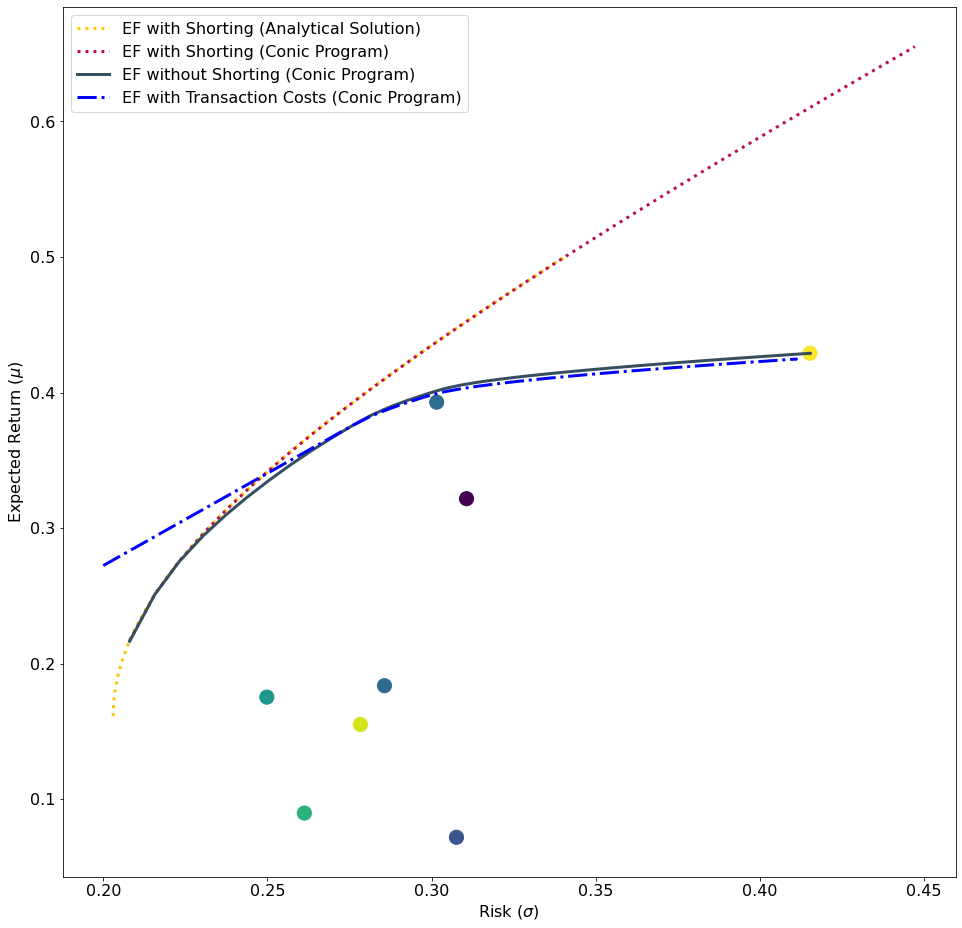

In [410]:
plt.figure(figsize=(16,16));

# Layout configurations
plt.rcParams['xtick.labelsize'] = 16.0;
plt.rcParams['ytick.labelsize'] = 16.0;

c = np.sqrt((20 * np.random.rand(len(mu)))**2);

# Plot assets
plt.scatter(sigma, mu, c=c, s=200);

# Get returns and risk
optimalReturnsConic = df_result['return'].values;
optimalStandardDeviationsConic = df_result['risk'].values;

optimalReturnsConicShorting = df_result_shorting['return'].values;
optimalStandardDeviationsConicShorting = df_result_shorting['risk'].values;

optimalReturnsConicTC = df_result_TC['return'].values;
optimalStandardDeviationsConicTC = df_result_TC['risk'].values;

# Plot above global mean-variance portfolio
plt.plot(optimalStandardDeviations[selectedRange], optimalReturns[selectedRange], c=COLORS[2], linestyle="dotted", linewidth=3, label="EF with Shorting (Analytical Solution)");
plt.plot(optimalStandardDeviationsConicShorting, optimalReturnsConicShorting, c=COLORS[1], linestyle="dotted", linewidth=3, label="EF with Shorting (Conic Program)");
plt.plot(optimalStandardDeviationsConic, optimalReturnsConic, c=COLORS[0], linestyle="-", linewidth=3, label="EF without Shorting (Conic Program)");
plt.plot(optimalStandardDeviationsConicTC, optimalReturnsConicTC, c='blue', linestyle="-.", linewidth=3, label="EF with Transaction Costs (Conic Program)");

# Show legend and axis labels
plt.xlabel("Risk ($\sigma$)", fontsize=16);
plt.ylabel("Expected Return ($\mu$)", fontsize=16);
plt.legend(fontsize=16);

# Save and show plot
plt.savefig('./Plots/EfficientFrontierTransaction.png', dpi=200);
plt.show()

## Efficient Frontier: Out-of-Sample Testing

We draw 50 random samples from the true distribution and compute the efficient frontier. We do this 10 times.

But first, the purpose of demonstration, let's test the ability to recover the covariance matrix.

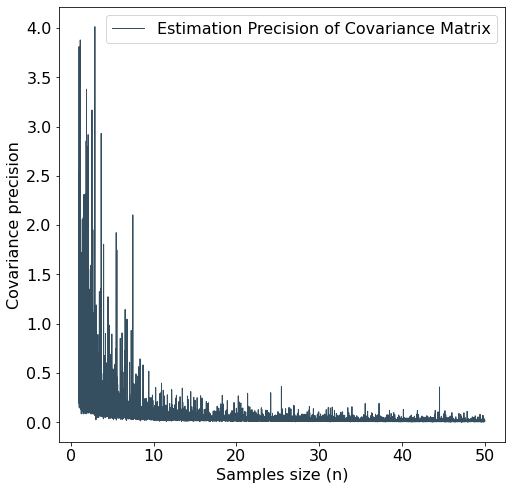

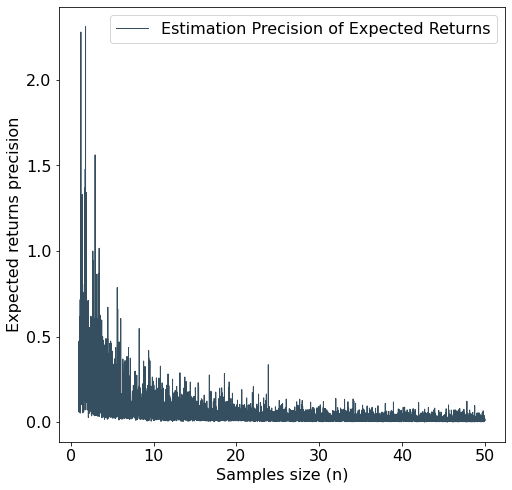

In [472]:
sampleSizesTest = np.linspace(1,50,10000);
estimatesSigma = np.zeros(len(sampleSizesTest));
estimatesMu = np.zeros(len(sampleSizesTest));

for i in range(len(estimatesSigma)):
    samples = np.random.multivariate_normal(mu, Sigma, size = int(np.ceil(sampleSizesTest[i])))
    muHat = np.mean(samples, axis=0)
    sigmaHat = np.cov(samples, rowvar=False)
    estimatesSigma[i] = np.sum((sigmaHat - Sigma)**2);
    estimatesMu[i] = np.sum((mu - muHat)**2);

plt.figure(figsize=(8,8));
plt.plot(sampleSizesTest, estimatesSigma, c=COLORS[0], linestyle="-", linewidth=1, label="Estimation Precision of Covariance Matrix");

# Show legend and axis labels
plt.xlabel("Samples size (n)", fontsize=16);
plt.ylabel("Covariance precision", fontsize=16);
plt.legend(fontsize=16);

# Save and show plot
plt.show()

plt.figure(figsize=(8,8));
plt.plot(sampleSizesTest, estimatesMu, c=COLORS[0], linestyle="-", linewidth=1, label="Estimation Precision of Expected Returns");

# Show legend and axis labels
plt.xlabel("Samples size (n)", fontsize=16);
plt.ylabel("Expected returns precision", fontsize=16);
plt.legend(fontsize=16);

# Save and show plot
plt.show()

### Estimates: Expected Returns and Covariance

We start where both the returns and the covariance is estimated.

In [468]:
sampleSize = 100;
totalSamples = 20;

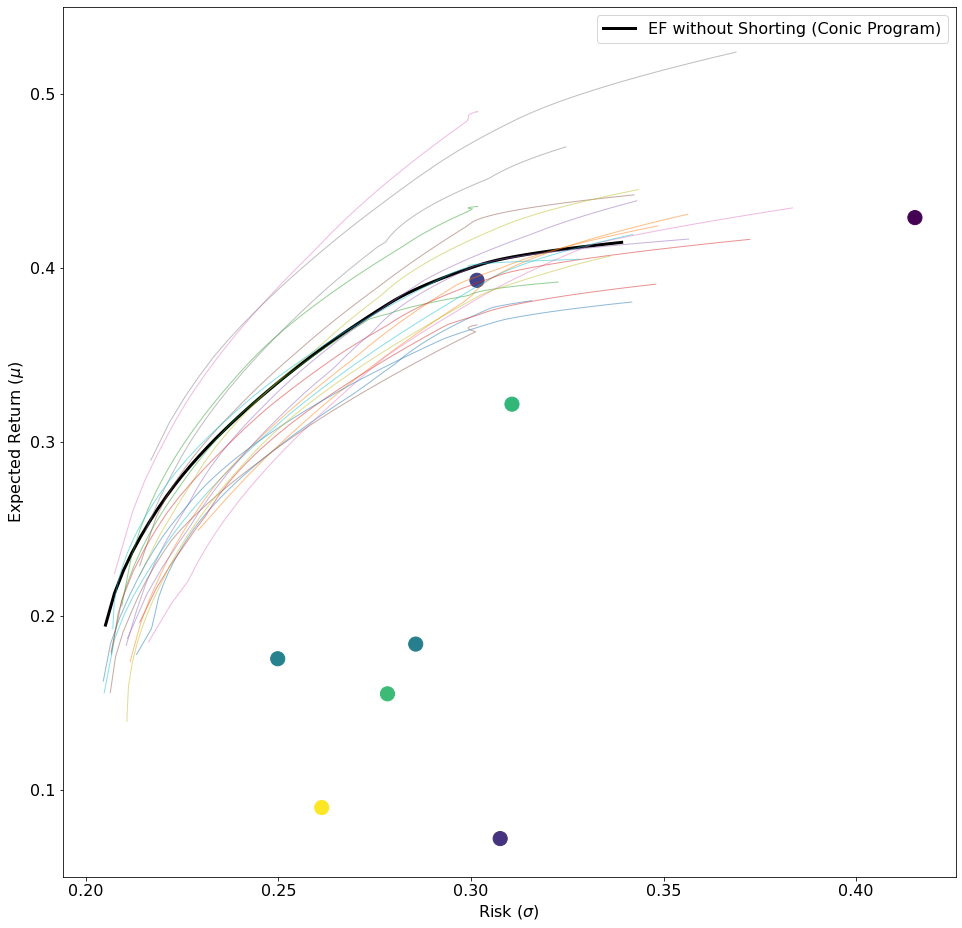

In [469]:
plt.figure(figsize=(16,16));

# Layout configurations
plt.rcParams['xtick.labelsize'] = 16.0;
plt.rcParams['ytick.labelsize'] = 16.0;

c = np.sqrt((20 * np.random.rand(len(mu)))**2);

# Plot assets
plt.scatter(sigma, mu, c=c, s=200);

# Get returns and risk
optimalReturnsConic = df_result['return'].values;
optimalStandardDeviationsConic = df_result['risk'].values;

optimalReturnsConicShorting = df_result_shorting['return'].values;
optimalStandardDeviationsConicShorting = df_result_shorting['risk'].values;

optimalReturnsConicTC = df_result_TC['return'].values;
optimalStandardDeviationsConicTC = df_result_TC['risk'].values;

# Plot above global mean-variance portfolio
plt.plot(optimalStandardDeviationsConic, optimalReturnsConic, c='black', linestyle="-", linewidth=3, label="EF without Shorting (Conic Program)");

for i in range(totalSamples):
    
    samples = np.random.multivariate_normal(mu, Sigma, size = sampleSize)
    muHat = np.mean(samples, axis=0)
    sigmaHat = np.cov(samples, rowvar=False)
    G = np.linalg.cholesky(sigmaHat)
    results = MVO_noShorting(G, muHat, N, gammas = np.linspace(0.02, 0.115, 100))
    portfolioReturns = results['return'].values;
    portfolioRisk = results['risk'].values;
    plt.plot(portfolioRisk, portfolioReturns, linewidth=1, alpha=0.5);


# Show legend and axis labels
plt.ylim([0.05,0.55])
plt.xlabel("Risk ($\sigma$)", fontsize=16);
plt.ylabel("Expected Return ($\mu$)", fontsize=16);
plt.legend(fontsize=16);

# Save and show plot
plt.savefig('./Plots/EfficientFrontierSimulations.png', dpi=200);
plt.show()

### Estimates: Expected Returns (Covariance Fixed)

Then we try to fix the covariance matrix.

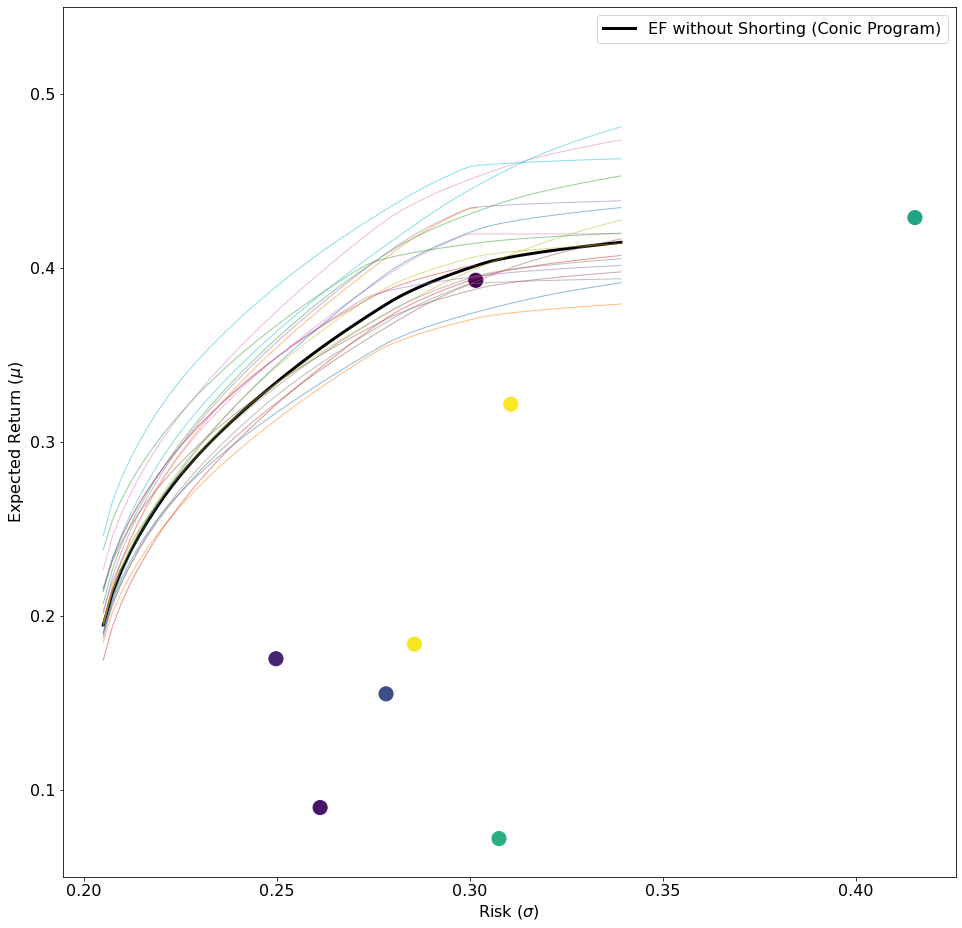

In [470]:
plt.figure(figsize=(16,16));

# Layout configurations
plt.rcParams['xtick.labelsize'] = 16.0;
plt.rcParams['ytick.labelsize'] = 16.0;

c = np.sqrt((20 * np.random.rand(len(mu)))**2);

# Plot assets
plt.scatter(sigma, mu, c=c, s=200);

# Get returns and risk
optimalReturnsConic = df_result['return'].values;
optimalStandardDeviationsConic = df_result['risk'].values;

optimalReturnsConicShorting = df_result_shorting['return'].values;
optimalStandardDeviationsConicShorting = df_result_shorting['risk'].values;

optimalReturnsConicTC = df_result_TC['return'].values;
optimalStandardDeviationsConicTC = df_result_TC['risk'].values;

# Plot above global mean-variance portfolio
plt.plot(optimalStandardDeviationsConic, optimalReturnsConic, c='black', linestyle="-", linewidth=3, label="EF without Shorting (Conic Program)");

for i in range(totalSamples):
    
    samples = np.random.multivariate_normal(mu, Sigma, size = sampleSize)
    muHat = np.mean(samples, axis=0)
    G = np.linalg.cholesky(Sigma)
    results = MVO_noShorting(G, muHat, N, gammas = np.linspace(0.02, 0.115, 100))
    portfolioReturns = results['return'].values;
    portfolioRisk = results['risk'].values;
    plt.plot(portfolioRisk, portfolioReturns, linewidth=1, alpha=0.5);


# Show legend and axis labels
plt.ylim([0.05,0.55])
plt.xlabel("Risk ($\sigma$)", fontsize=16);
plt.ylabel("Expected Return ($\mu$)", fontsize=16);
plt.legend(fontsize=16);

# Save and show plot
plt.savefig('./Plots/EfficientFrontierSimulationsFixedCovariance.png', dpi=200);
plt.show()

### Estimates:  Covariance (Expected Returns Fixed)

Then we try to fix the returns.

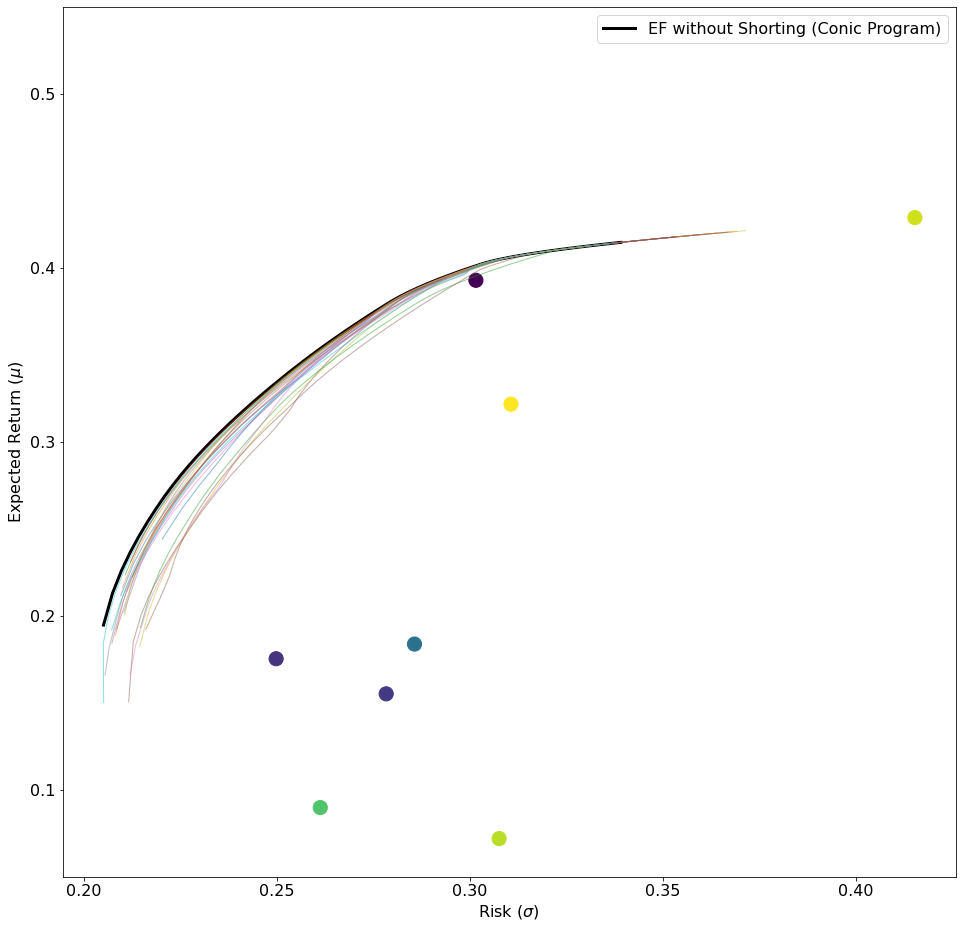

In [471]:
plt.figure(figsize=(16,16));

# Layout configurations
plt.rcParams['xtick.labelsize'] = 16.0;
plt.rcParams['ytick.labelsize'] = 16.0;

c = np.sqrt((20 * np.random.rand(len(mu)))**2);

# Plot assets
plt.scatter(sigma, mu, c=c, s=200);

# Get returns and risk
optimalReturnsConic = df_result['return'].values;
optimalStandardDeviationsConic = df_result['risk'].values;

optimalReturnsConicShorting = df_result_shorting['return'].values;
optimalStandardDeviationsConicShorting = df_result_shorting['risk'].values;

optimalReturnsConicTC = df_result_TC['return'].values;
optimalStandardDeviationsConicTC = df_result_TC['risk'].values;

# Plot above global mean-variance portfolio
plt.plot(optimalStandardDeviationsConic, optimalReturnsConic, c='black', linestyle="-", linewidth=3, label="EF without Shorting (Conic Program)");

for i in range(totalSamples):
    
    samples = np.random.multivariate_normal(mu, Sigma, size = sampleSize)
    sigmaHat = np.cov(samples, rowvar=False)
    G = np.linalg.cholesky(sigmaHat)
    results = MVO_noShorting(G, mu, N, gammas = np.linspace(0.02, 0.115, 100))
    portfolioReturns = results['return'].values;
    portfolioRisk = results['risk'].values;
    plt.plot(portfolioRisk, portfolioReturns, linewidth=1, alpha=0.5);

# Show legend and axis labels
plt.ylim([0.05,0.55])
plt.xlabel("Risk ($\sigma$)", fontsize=16);
plt.ylabel("Expected Return ($\mu$)", fontsize=16);
plt.legend(fontsize=16);

# Save and show plot
plt.savefig('./Plots/EfficientFrontierSimulationsFixedMu.png', dpi=200);
plt.show()